# Ahead of the Game: Coaching Predictability in NCAA Football

This notebook is Part I in a series that seeks to model the predictability of offenseive playcallers in the NCAA FBS football league. While this idea could be practically applied to any offensive playcaller in the game, we will use Lincoln Riley, the head coach of the Oklahoma Sooners, as a singular case study.

![](https://bloximages.newyork1.vip.townnews.com/oudaily.com/content/tncms/assets/v3/editorial/3/18/3188a808-1922-11ea-988f-473c9fa86f91/5debf40bd8b17.image.jpg?resize=400%2C267)

Lincoln Riley is known for being an exceptionally talented playcaller, but is he as unpredicatable as analysts make him out to be? We will find out through the course of this notebook.

**NOTE: This notebook is meant to be used in [Google Colaboratory](https://colab.research.google.com). The instructions will assume as much, and may not be accurate if you're using a different platform.**

Ok, let's begin. Start by importing the required modules and setting a random seed. This random seed let's us have reproducible results. The seeding function has been buggy for me, so please excuse if the numbers and plots I describe don't match the outputs of all the cells.

In [0]:
from numpy.random import seed
import random

seed(485)
random.seed(485)

In [0]:
import pandas as pd
import numpy as np
import tensorflow

## Preparing our Data

The data we will be using was scraped from [collegefootballdata.com](https://www.collegefootballdata.com)

Since we are using Lincoln Riley as our case study, it consists of (presumably) every play that Lincoln Riley called as either an offensive coordinator or head coach during his tenures at Eastern Carolina and Oklahoma.

First, import the data. To do this on Google Colab, you will first need to download the "coachingData.csv" from the models folder in the [GitHub repository](https://github.com/westpoint-neural-networks/final-project-NickL73). Next, you will need to click on the folder icon on the toolbar to the left of Google Colab and upload the dataset.

Once you have done that, load it into a Pandas dataframe and we'll inspect the data.

In [0]:
df = pd.read_csv('/content/coachingData.csv')
df

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance,play_type
0,7,True,2,1870,70,93,1,10,Pass
1,0,True,1,3368,1568,92,2,6,Pass
2,0,True,2,2470,670,90,1,10,Pass
3,8,False,1,2812,1012,87,1,20,Pass
4,-8,False,2,2258,458,87,1,10,Pass
...,...,...,...,...,...,...,...,...,...
9506,27,False,2,1861,61,1,1,1,Rush
9507,34,False,4,375,375,1,3,1,Rush
9508,42,False,3,1563,1563,1,2,1,Rush
9509,7,True,1,3387,1587,1,3,1,Rush


You'll notice that the data comes with some nice work already done to it. Before loading the CSV, we conducted some feature cleaning and feature engineering to get the best possible set of features for use in our network. In general, these features are derived from the information that could be found on a scoreboard. You'll notice our target feature, **play_type**, is the last column in the DataFrame. This will be the what we eventually try to predict.


Now that we have our data in a Pandas data frame, we're going to start preparing it for use in a neural network. The first step we will take will be to formally define our target values (the play type) and input values (the scoreboard information) by [indexing](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html) our dataframe.


In [0]:
X = df.iloc[:,0:8]
y = df.iloc[:,8]

### Vectorizing the Data

For use in a neural network, each piece of data must be interpretable by a machine. This means things like our values of "True" and "False", as well as our target values of "Rush" and "Pass", must be converted into some number. To do this, we will simply binarize the data.

In [0]:
X = X.replace({True:1, False:0})
y = y.replace({'Rush':0, 'Pass':1})

Additionally, since we want to predict a specific binary category of play_type, we will use the built-in Keras utility **to_categorical** to automatically create two seperate targets that the model can "choose" between when making predictions. We can see what this looks like be executing the next block of code.

In [0]:
from keras.utils import to_categorical
y = to_categorical(y)
y

Using TensorFlow backend.


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Splitting the Data

In order to use a loss function in training our model, we will need to split the data into a training set and a validation set. However, we only have one data set, so we will need to split it.

Using the scikit-learn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function, we will split our data into two. This function automatically shuffles our data, which helps us avoid training on only a range of years and validating on a different set of years. This will help increase the generality of our model.

We will use 85% of the data in the training set, and the remaining 15% of the data in the validation set.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15)

###Scaling and Normalizing the Data

As you probably saw in the original DataFrame, each feature in our dataset has a significantly different range of values. This makes it hard for a neural network to properly make connections and relationships between values.

To improve the accuracy of our model, we will need to scale and transform all of our data so that the mean centers on 0 and the minimum and maximum values of a feature are just one standard deviation away from the mean. This will put all of our values into a much more reasonable range, and each feature's range will be fairly similar.

To do this, we will apply the sklearn [StandardScaler](https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set) to the features of our DataFrame that are not binary 1's or 0's. We will start by fitting the StandardScaler to our **training data only** and transforming all values in the **training data** to that scale. It's very important that we do not do this to the validation data at the same time, as that would cause data leakage in the model and decrease the overall accuracy of our model. 

In [0]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
numeric = ['score_differential', 'period', 'seconds_remaining', 'secondsInHalf', 'yardsToGoal', 'down', 'distance']
scaled_features = X_train.copy()
features = scaled_features[numeric]
scaler = ss.fit(features.values)
features = ss.transform(features.values)

scaled_features[numeric] = features

X_train = scaled_features
X_train

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
3671,-0.010096,1,-0.436965,0.833389,0.008382,0.621726,1.543166,0.402360
3119,-0.270233,1,-0.436965,0.654470,-0.337810,0.824789,1.543166,1.951379
1627,-0.270233,1,-1.318750,1.529287,1.354886,-0.677882,1.543166,-1.404828
8200,0.640246,0,-0.436965,0.082873,-1.443802,-0.596657,-0.919077,0.402360
1133,0.900383,0,-0.436965,0.313584,-0.997397,-0.068691,-0.919077,0.402360
...,...,...,...,...,...,...,...,...
2414,-0.270233,1,-0.436965,0.002831,-1.598677,-1.815039,-0.919077,-1.146658
1601,1.290588,0,-0.436965,0.057448,-1.492998,-0.515431,0.312044,-1.146658
174,-0.465336,1,-1.318750,1.052799,0.432922,0.418662,0.312044,-0.630319
8600,0.054938,1,1.326604,-1.089514,-0.432557,-0.759108,-0.919077,0.402360


As you can see, our data is completely unrecognizable. That's okay. Even if we can't make much sense of it, the computer understands it perfectly well.

Now, we're ready to scale the validation data. One nice thing about using the sklearn StandardScaler is that it saves the the mean and standard deviations from the last time it was fit. This means that we can transform future data on the same scale used to transform the training data.

That's exactly what we're going to do with the validation data. At this point, it's very important that we do not instantiate a new StandardScaler nor fit existing StandardScaler to the validation data. We just want to use that scale to transform the validation data.

In [0]:
scaled_features = X_validation.copy()
features = scaled_features[numeric]
features = ss.transform(features.values)

scaled_features[numeric] = features

X_validation = scaled_features
X_validation

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
4750,2.461204,0,0.444819,-0.341823,1.014160,0.784177,-0.919077,0.402360
6349,1.160520,0,1.326604,-1.395558,-1.024728,-0.109304,-0.919077,0.402360
4012,-1.440849,0,0.444819,-0.384198,0.932167,-1.855652,2.774287,-1.921168
3070,0.640246,0,-0.436965,0.258966,-1.103076,1.068466,-0.919077,0.402360
8053,-0.660438,1,-0.436965,0.268383,-1.084856,0.743564,0.312044,-1.404828
...,...,...,...,...,...,...,...,...
6241,0.445143,0,0.444819,-0.127121,1.429590,0.540500,0.312044,-1.146658
3675,-1.180712,0,-1.318750,0.993474,0.318132,0.621726,1.543166,-0.113979
7106,-0.270233,1,-1.318750,1.489737,1.278359,-1.936877,-0.919077,-1.921168
8699,-2.286294,0,1.326604,-1.146956,-0.543703,2.002559,0.312044,0.402360


Perfect. Now that all of our data has been vectorized, scaled, and transformed, we're ready to start building our model.

##Building a Model

We're going to use Keras to create a densely connected network for this binary classification task.

The number of layers, hidden units, and amount of dropout all came from a large amount of manual tuning to produce a low level of  validation loss and high validation accuracy.

In this model, our densely connected layers use the **elu** activation function. This came as the result of many trials using **relu** and **tanh** and discovering that **elu** resulted in much better results.

In our final layer, we use a **sigmoid** activation function to give us a probability distribution between our two possible target values (rush or pass). This is standard practice in binary classification tasks, as well as the use of **binary crossentropy** as a loss function.

In [0]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(8,activation='elu', input_dim=8))
model.add(layers.Dense(8,activation='elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

With our sequential model built and compiled, we're ready to begin training. We'll train for 150 epochs for this model. Through testing, we found 150 epoch to be a good number that prevented too much overfitting.

Okay, let's train.

In [0]:
history2 = model.fit(X_train, y_train,batch_size=24, epochs=150, validation_data=(X_validation, y_validation))

Epoch 1/150
337/337 [==============================] - 1s 2ms/step - loss: 0.7333 - accuracy: 0.5285 - val_loss: 0.6837 - val_accuracy: 0.5543
Epoch 2/150
337/337 [==============================] - 1s 2ms/step - loss: 0.6869 - accuracy: 0.5760 - val_loss: 0.6763 - val_accuracy: 0.5781
Epoch 3/150
337/337 [==============================] - 1s 1ms/step - loss: 0.6768 - accuracy: 0.5860 - val_loss: 0.6733 - val_accuracy: 0.5788
Epoch 4/150
337/337 [==============================] - 1s 2ms/step - loss: 0.6711 - accuracy: 0.5936 - val_loss: 0.6720 - val_accuracy: 0.5795
Epoch 5/150
337/337 [==============================] - 1s 2ms/step - loss: 0.6675 - accuracy: 0.5962 - val_loss: 0.6703 - val_accuracy: 0.5781
Epoch 6/150
337/337 [==============================] - 0s 1ms/step - loss: 0.6669 - accuracy: 0.5977 - val_loss: 0.6706 - val_accuracy: 0.5851
Epoch 7/150
337/337 [==============================] - 0s 1ms/step - loss: 0.6650 - accuracy: 0.5997 - val_loss: 0.6707 - val_accuracy: 0.5893

Let's take a look at the model's performance in terms of accuracy.

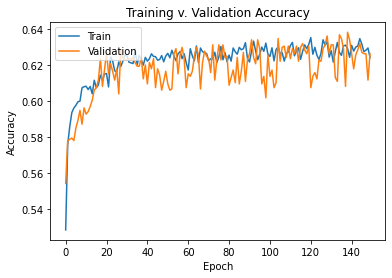

In [0]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training v. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Okay, this is actually pretty decent. The validation and training accuracies track each other fairly well and we don't see much evidence of overfitting or underfitting. With a final validation accuracy of 62.65%, let's take a look at the loss.

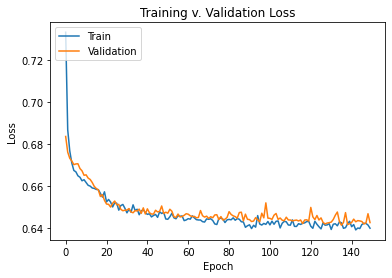

In [0]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training v. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Like we saw in the accuracy, we see a close tracking between the training and validation losses. This model looks to be about as good as it will get, so let's save it and test it out.

**NOTE: The next block of code will save the model to the same content folder as our dataset in the Colab runtime. If you want to keep the model, be sure to right click and download it from the Colab directory.**

In [0]:
model.save('coachingModel.h5')

##Testing the Model

To test how good our model is on unseen data, we will use it to try to predict every play in the 2019 Big XII Championship Game between Oklahoma and Baylor. Since our model did not train or validate on any play from this game, it should be a good test of how well our model generalizes on new data.

To begin, we have to go through the same process of uploading the test dataset to Colab, setting our target values, and vectorizing and transforming the data for use in a neural network.

Again, we must be careful to only transform the test set to the scale saved in the StandardScaler, which was fit on the test data at the beginning of the notebook. This is important in the test set because in a real-life scenario, the only context for scale we would have as plays occur would be every play that's previously occured.

In [0]:
testDF = pd.read_csv('/content/test.csv')
XGame = testDF.iloc[:,0:8]
yGame= testDF.iloc[:,8]

XGame = XGame.replace({True:1, False:0})
yGame = yGame.replace({'Rush':0, 'Pass':1})
yGame = to_categorical(yGame)

scaled_features = XGame.copy()
features = scaled_features[numeric]
features = ss.transform(features.values)

scaled_features[numeric] = features

XGame = scaled_features
XGame

,score_differential,oneScoreGame,period,seconds_remaining,secondsInHalf,yardsToGoal,down,distance
0,0.185006,1,-1.318750,1.151675,0.624239,-1.205848,0.312044,0.402360
1,0.380109,0,-0.436965,0.682721,-0.283148,0.906015,-0.919077,0.402360
2,0.185006,1,-0.436965,0.340892,-0.944557,0.499887,1.543166,1.176870
3,-0.270233,1,-0.436965,0.069689,-1.469311,1.515206,1.543166,0.144191
4,0.185006,1,1.326604,-1.111172,-0.474465,-1.693201,1.543166,-0.372149
...,...,...,...,...,...,...,...,...
69,0.185006,1,-1.318750,1.371086,1.048779,-1.733814,0.312044,-0.630319
70,0.185006,1,2.208388,-2.556645,-3.271331,-1.774426,0.312044,-1.146658
71,0.185006,1,-1.318750,1.144142,0.609662,-1.205848,1.543166,0.402360
72,0.380109,0,-0.436965,0.649762,-0.346921,0.459275,-0.919077,0.402360


Looks good. Now let's use our model to evaluate the game and see how well we do.

###Model Performance

With our test data all set up for input into our model, we are ready to test it out. We can use the Keras **evaluate** model function to get predictions for every play in the dataset.

In [0]:
model.evaluate(XGame, yGame)

3/3 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.5946


[0.6990373134613037, 0.5945945978164673]

In this test set we only get about a 59.45% accuracy, even though we had a 62.65% final validation accuracy.  This 3% difference may seem significant, and it surely is, but our test set only had 74 plays in it. As such, in the context of this test set, we only got about two more predictions incorrect than our validation set would have us believe we are capable of.

Let's take a closer look using the sklearn **classification report** which has several parameters beyond just accuracy which may help us better understand the behaviour of our model:


*   *Precision* - The ratio of true positives to true positives plus false positives. In other words, the percentage of predictions that were correct for a given class.
*   *Recall* - The ratio of true positives to true positives plus false positives. In other words, the percentage of instances of a certain class that were correctly identified.
*   *f1-score* - The harmonic mean between precision and recall. Typically, this value is a bit more informative than just plain accuracy.
* *support* - The number insances of a certain class in the test set.





In [0]:
from sklearn.metrics import classification_report

Y_test = np.argmax(yGame, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(XGame)
print(classification_report(Y_test, y_pred, target_names=['Rush', 'Pass'], digits=4))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

        Rush     0.7576    0.5319    0.6250        47
        Pass     0.4634    0.7037    0.5588        27

    accuracy                         0.5946        74
   macro avg     0.6105    0.6178    0.5919        74
weighted avg     0.6502    0.5946    0.6009        74



Reading this chart, we are able to deduce that our model guesses "Pass" more often than "Rush'. Since Pass has low precision, and high recall, we must be guessing pass a lot. 

In the context of football, this is probably a good thing- to over guess on pass, instead of rush. Pass plays potentially result in large gains and scoring opportunities. If we predict pass plays more often, we would position our defense in such a way to prevent these big plays from happening too often.

##Conclusion

This notebook explored whether or not we could evaluate the predictability of Lincoln Riley using data derived from the information available on the scoreboard.

Ultimately, we were able to produce a model that achieved around 60% accuracy on a single test game. This may not seem that high, but we must remember that in the context of football, it pays to be unpredictable. If a coach were predictable, they surely would not have the same success that Lincoln Riley has experienced.

We can get better, though. I'm sure of it. Let's see if we can use the Big XII Conference to predict Lincoln Riley's play-calling behavior. Perhaps he simply calls plays in the way that all of the coaches in the Big XII do. We will explore this idea in Part II of this series, [building a conference model](https://colab.research.google.com/drive/19qggMX5b_FWNvDxkJsxlwpzjAHW4fKl2#offline=true&sandboxMode=true).

